<a href="https://colab.research.google.com/github/elio-samaha/AI/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from typing import Optional, Tuple

np.set_printoptions(precision=3)

# INF 554 Lab 1: Introduction to the Machine Learning Pipeline

## Introduction

The goal of this lab is to demonstrate the *machine learning pipeline*. We cover a step by step overview of a typical machine learning task, and at each step describe the subtasks that need to be performed. For further information regarding the concepts relevant to this lab, see the lecture slides.

## The Task and Data

Data is available in the ```data``` folder. This data consists of rows of measurements associated with cell growth in Scots pine trees monitored in the commune of Walscheid in France. Each row corresponds to the data of one week. The features (we shall denote by variables $X_1,\ldots,X_3$) are: the week number, the average measured temperature, and soil moisture over that week. The final column (we shall denote $Y$) is the target; the number of new cells (known as *tracheids*) measured during the corresponding week (the number is an average over measurements from several trees). Let $\mathbf{X} \in \mathbf{R}^{n \times 3}$ be the instances ($n$ weeks; i.e., each row $\mathbf{x}_i$ is an instance; corresponding to realizations of $X_1,\ldots,X_3$, associated with label $y_i$); and $\mathbf{y} = [y_1,\ldots,y_n]^\top$ are the labels.

Counting cells involves manually extracting micro-core samples from the tree, and counting the cells under a microscope. Therefore it would be time saving and beneficial if a computational model was constructed, such that an estimate of growth could be made automatically given the environmental measurements such as temperature and daylight hours (which are easily and automatically obtainable), i.e., a data-driven model. Furthermore, the model could be analyzed for greater understanding of growth drivers, and we could also build a forecasting model.

## Implementation of a Machine Learning Pipeline

In this section, a machine learning pipeline will be implemented to load and preprocess the data, and from this data to build and evaluate a regression model. Each of the following subsections include tasks to be completed. In each case, you will need to complete the code in the Notebook cells where requested. The data is contained in the ```data``` folder.

## Inspecting the Data

The training data is loaded and stored in ```X``` and ```y```, respectively. The distribution of each variable can be inspected by, for example, using ```Matplotlib```'s ```hist``` function. Notice/recall that in Python the first feature is indexed at ```0```, whereas we refer to $X_1$ in mathematical notation. Therefore the second feature is indexed at ```1```, and so on. Execute the next cell and observe the result.


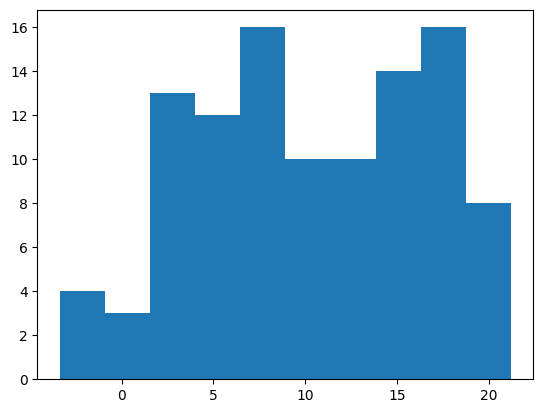

In [14]:
# Load the data

data_train = np.loadtxt('data_train.csv', delimiter=',', dtype=np.dtype("float64"))

# Prepare the data

X = data_train[:,0:-1]
y = data_train[:,-1]

# Inspect the data

plt.figure()
plt.hist(X[:,1], 10)
plt.show()

The next cell shows the plot of $X_3$ versus $X_2$

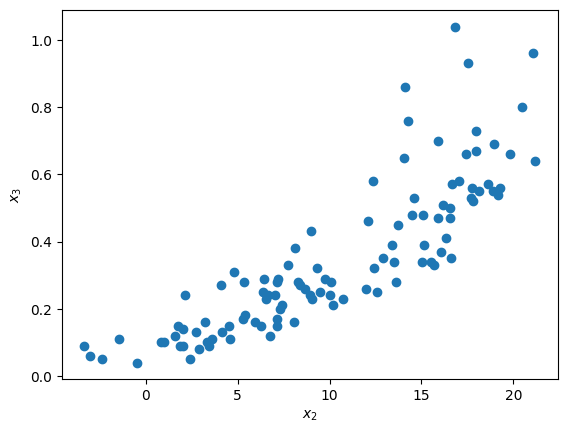

In [15]:
plt.figure()
plt.plot(X[:,1],X[:,2], 'o')
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

> **Task 1:** Build the histogram for all other variables, then also plot $X_1$ (week number) versus the target (number of cells).

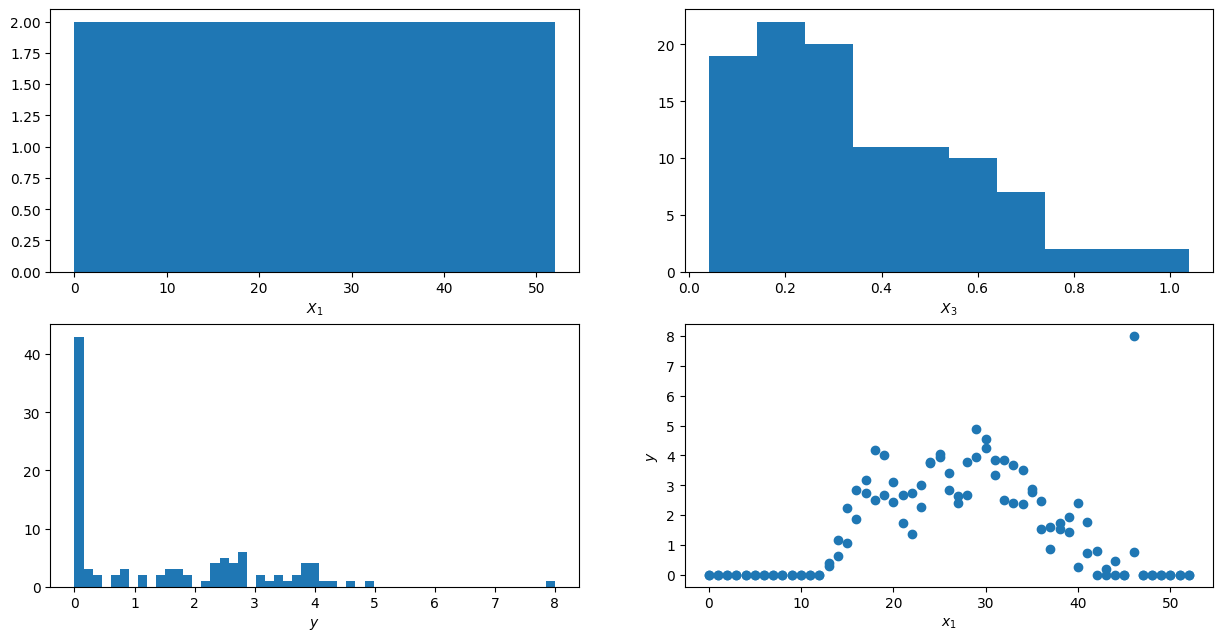

In [16]:
#your code for Task 1 here

plt.figure(figsize = (15 , 7.5))
plt.subplot(2,2,1)
plt.hist(X[:,0], 53)
plt.xlabel('$X_1$')

plt.subplot(2,2,2)
plt.hist(X[:,2], 10)
plt.xlabel('$X_3$')

plt.subplot(2,2,3)
plt.hist(y, 53)
plt.xlabel('$y$')

plt.subplot(2,2,4)
plt.plot(X[:,0], y , 'o')
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.show()

# plt.plot()

The correlation between $X_1$ (week number) and the target variable (number of cells) should show how the growth season starts at about the 12th week of the year, peaks in the summer months, before ceasing in the final months of the year.

## Preprocessing

Preprocessing is a fundamental step in the machine learning pipeline. In practice, it takes up most of the time. It can involve cleaning the data, dealing with missing values, removing outliers, dimensionality reduction, feature selection and feature engineering. Usually preprocessing is guided by the data exploration process (inspecting the data). For example, there appears to be at outlier in the target column, possibly caused by an $8$ being recorded instead of a $0$. We will come back to this later at evaluation time.

In the data exploration phase it was also noticeable that the attributes were of different scales. A common technique is to standardize each attribute to mean $0$ and standard deviation $1$ so that each variable will be considered equally.

In the following, we want to standardize the train data by computing its mean and stardard deviation. However, the validation and testing data should be standardized with the mean and the standard deviation of the train set. For example imagine we train the model on data measured on the whole year and test it with data measured only during winter. Then, the testing data will be pre-processed very differently, because as we observed the features are different during winter. However, the testing data should be pre-processed similarly, because they will be used with a model trained on the whole year.

> **Task 2:** Complete the ```preprocess``` function below to standardize the data of each of the input attributes. Save the mean and standard deviation of the train set in `train_mean` and `train_std` variables for future use. Hint: NumPy has a ```mean``` function. Calling ```mean(X,axis=0)``` will return a vector of means, one for each column. The function ```std``` can be used in a similar way for the standard deviation.


In [17]:
print(np.mean(X, axis=0)) #you should obtain array([26.   , 10.23 ,  0.358])

def preprocess(
        X: np.ndarray,
        force_mean: Optional[np.ndarray] = None,
        force_std: Optional[np.ndarray] = None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    """Pre-process the dataset by normalizing it.
    You can optionally provide `force_mean` and `force_std` parameters
    to use the same mean and standard deviation as for another dataset.

    :param X: The data to normalize
    :param force_mean: If not None, will be used instead of the mean of the dataset
    :param force_std: If not None, will be used instead of the std of the dataset
    :returns: The tuple (X_preprocessed, m, s) where `m` and `s` are the mean and
        standard deviation that were used during pre-processing
    """

    #insert here your solution for Task 2
    if force_mean is None:
        m = np.mean(X, axis=0)
    else:
        m = force_mean

    if force_std is None:
        s = np.std(X, axis=0)
    else:
        s = force_std

    return (X -m)/s, m, s

X_std, train_mean, train_std = preprocess(X)

[26.    10.192  0.349]


## Building a Model

A standard approach for regression tasks (such as this one, where the target label is continuous) is *ordinary least squares* (OLS). However, OLS is a linear model, yet we observed previously that the relationship of the $X_1$ feature is non-linear with respect to $Y$. To fit a linear model which captures non-linear dependencies between the features and the labels, we can use polynomial basis functions to create a new feature space to which we fit a linear model. This has been included in the preprocessing (N.B. It is a matter of perspective whether this step is considered part of building the model, or data preprocessing) via the function ```phi```, where the second parameter indicates the degree to the polynomial. Using degree $2$ would produce a new feature space

$$
	\mathbf{z} = \phi(\mathbf{x}) = [1,x_1,x_2,x_3,x^2_1,x^2_2,x^2_3]
$$

for an instance $\mathbf{x}$. For degree $1$, this is equivalent to the original feature space,

$$
	\mathbf{z} = \phi(\mathbf{x}) = [1,x_1,x_2,x_3]
$$

except that we have added a column of $1$s to the new input feature space. This is common practice so that the intercept/bias does not need to be calculated separately.

Our model is fit to this data by obtaining an ideal set of coefficients:

$$
	\mathbf{\hat\beta} = [\beta_0,\beta_1,\ldots,\beta_m]^\top
$$

where $m$ is the length of vector $\mathbf{z}$. And where $\mathbf{\hat\beta}$ refers to the values which minimize the mean squared error (or equivalently, sum of squares error) over the data; which is our given/assumed loss metric; given in Eq. (2) (where it is later used for evaluation). Having $\mathbf{\hat\beta}$, we can now make a prediction for any test point;

$$
	\hat{y} = \mathbf{z\hat\beta}
$$

> **Question 1**: Derive $\mathbf{\hat\beta}$, by minimizing Eq. (2); setting it to $0$ and solving for $\mathbf{\hat\beta}$.

You should have obtained

\begin{equation}
	\mathbf{\hat\beta} = (\mathbf{Z}^\top\mathbf{Z})^{-1}\mathbf{Z}^\top\mathbf{y} \hspace{1.5cm} (1)
\end{equation}
(or equivalent).

> **Task 3**: Implement OLS in Python, to obtain a vector of coefficients. Hint: Since Python 3.6 you can use the ```@``` symbol for matrix multiplication. Print out the coefficients using the ```print``` function.


In [18]:
# Feature creation

def phi(X, degree):
    N,D = X.shape
    for d in range(2,degree+1):
        X = np.column_stack([X,X[:,0:D]**d])
    Z = np.column_stack([np.ones(len(X)), X])
    return Z

# Polynomial degree
degree = 2

def OLS(X, degree, y):
    Z = phi(X, degree)
    beta = np.linalg.inv(Z.T @ Z) @ Z.T @ y
    return (beta, Z)

(beta_hat, Z) = OLS(X_std, degree, y)
print(beta_hat)

[ 1.708  0.187  0.887 -0.054 -0.528  0.23   0.097]


> **Question 2**: What could go wrong in building this model? Specifically, wrt Eq. (1) ?

## Evaluation and Model Selection

Before deploying a model, we should evaluate it to know how useful it is. For this purpose we have held aside some ***validation** data*. It is important to conduct an identical preprocessing on the validation data as the train data; noting that the training procedure is done in complete ignorance of the validation data.

> **Task 4**: Load and preprocess the validation data (```data_valid.csv```). Use different variable names (for example, ```X_valid``` and ```y_valid```)


In [19]:
import pandas as pd
#insert here your solution for Task 4
data_valid = np.loadtxt('data_valid.csv', delimiter=',', dtype=np.dtype("float64"))

# Prepare the data

X_valid = data_valid[:,0:-1]
y_valid = data_valid[:,-1]

X_valid_std, _, _ = preprocess(X_valid, train_mean, train_std)
Z_valid= phi(X_valid_std, degree)

We now evaluate the quality of predictions. For this task we use the *mean squared error* as the loss metric, over $N$ examples as
\begin{equation}
	\textsf{MSE}(\mathbf{\hat\beta}) = \frac{1}{N}\sum_{i=1}^N (y_i - \hat{y}_i)^2  \hspace{1.5cm} (2)
\end{equation}

> **Task 5**: Implement MSE, i.e., a function such that ```mse = MSE(y_valid,y_pred)```. Print out the value obtained. Hints: You can make use of ```mean``` again.


In [20]:
#your code for Task 5
def mse(yt,yp):
  return np.mean((yt - yp)**2)


print('The MSE of our linear model is:\t', mse(y_valid, Z_valid @ beta_hat))

The MSE of our linear model is:	 0.9037430481422564


> **Task 6**: Additionally, calculate the MSE where all predictions for validation examples are simply the mean of $Y$ in the training data (i.e., a *baseline*).

In [21]:
#insert here your solutions for Task 6

print('The MSE of our baseline model is: \t', mse(y_valid, np.ones(len(y_valid)) * np.mean(y)))


The MSE of our baseline model is: 	 2.1857265307938776


So far, you should obtain something like the following.

        beta_hat =  [ 1.708,  0.187,  0.887, -0.054, -0.528,  0.23 ,  0.097]
        MSE on validation data   0.9037430481422564
        MSE baseline             2.1857265307938776
          
> **Task 7**: What is the change to MSE if we replace the outlier with a different value (e.g., $0$)?

In [22]:
#insert here your solution for Task 7

# X = data_train[:,0:-1]
# y = data_train[:,-1]

# print(np.where(y == 8))

y_outlier_removed = y
y_outlier_removed[y_outlier_removed >= 8] = 0

beta_hat, Z = OLS(X_std, degree, y_outlier_removed)

y_pred = Z_valid @ beta_hat

print('The MSE of our linear model where the outlier was replaced is:\t', mse(y_valid, y_pred))

The MSE of our linear model where the outlier was replaced is:	 0.8659253633320069


> **Question 3**: Outliers can have a powerful influence on model accuracy. Explain this influence with regard to Eq (2).

Why is it important to use a *validation set* for evaluation and not just simply measure the MSE on the training data that we had originally? The answer is to avoid **overfitting**. Overfitting can be demonstrated by comparing results on the training and validation sets for different parameter configurations.

> **Task 8** : Evaluate the MSE with the degree of polynomial varying from 1 to 8 (**Note**: remove the outlier).

> Hints: put the test procedure in a loop, incrementing the degree of polynomial in the expansion each time, then use plotting functions as demonstrated in the earlier tasks; at each iteration of the loop you will need to obtain predictions on both the training and validation data using your ```MSE``` function.


In [23]:
def plot_fig(first, second, labels, max_it):
    plt.figure()
    plt.plot(range(1,max_it), first, '-')
    plt.plot(range(1,max_it), second, '-')
    plt.xlabel('degree of polynomial')
    plt.ylabel('MSE')
    plt.legend(labels)

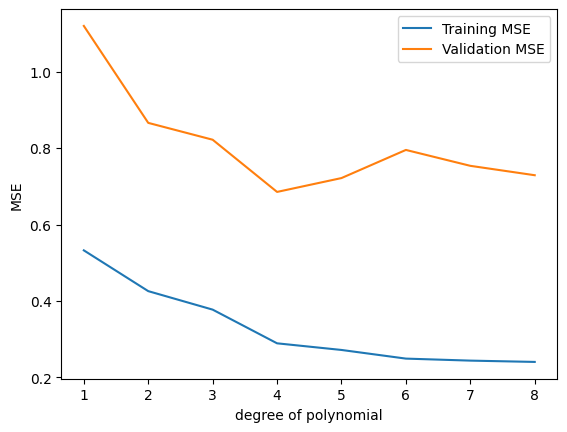

In [24]:
#insert here your solution for Task 8

mse_train = np.zeros(8)
mse_valid = np.zeros(8)

for degree in range(1, 9):

    beta_hat_degree, Z = OLS(X_std, degree, y_outlier_removed)

    Z_degree = phi(X_std, degree)
    Z_valid_degree = phi(X_valid_std, degree)

    mse_train[degree - 1] = mse(y, Z_degree@beta_hat_degree)
    mse_valid[degree - 1] = mse(y_valid, Z_valid_degree@beta_hat_degree)


plot_fig(mse_train, mse_valid, ['Training MSE', 'Validation MSE'], 9)

k = 4 works best

> **Question 4**: What degree of polynomial should you use in your final deployed model, according to your plot?

Validation is only a part of the evaluation of the model. Moreover, usually validation is done on a part of the training set that is held out to tune hyperparameters (such as the degree of the polynomial feature transformation) and have an idea of the generalization capabilities of the model. For this reason, we now proceed to *test* the model on a **test set**. You can imagine the test set as previously unseen data (for instance, you built a model using all the data until year 2022 for training and the data from 2023 for validation, but now you will have to test on next year's data).

> **Task 9** : Evaluate the model with the optimal parameter chosen above on the **test** set ```data_test.csv```. You will have to re-train the model after merging the training and validation set (you now can use validation as part of training because its best to use all available data).

In [39]:
#insert here your solution for Task 9

best_degree = 4

data = np.concatenate((data_train, data_valid), axis = 0)
X_concat = data[:,0:-1]
Y_concat = data[:,-1]

x_std_concat, concat_mean, concat_std = preprocess(X_concat)
beta_hat, Z = OLS(x_std_concat, best_degree, Y_concat)

print("MSE on train data  ", mse(Y_concat,Z@beta_hat))

data_test = np.loadtxt("data_test.csv" , delimiter=",", dtype=np.dtype("float64"))

X_test = data_test[:,0:-1]
y_test = data_test[:,-1]

x_std_test,_,_ = preprocess(X_test, concat_mean, concat_std)
Z_test = phi(x_std_test, best_degree)

y_pred = Z_test @ beta_hat

print("MSE on test data  ", mse(y_test,y_pred))

MSE on train data   0.40219491102183696
MSE on test data   0.36020903198650034



> **Task 10** : Repeat the evaluation of Task 8 on the test data (using values from 1 to 8 for the degree). Would you confirm the same choice for the degree of polynomial?

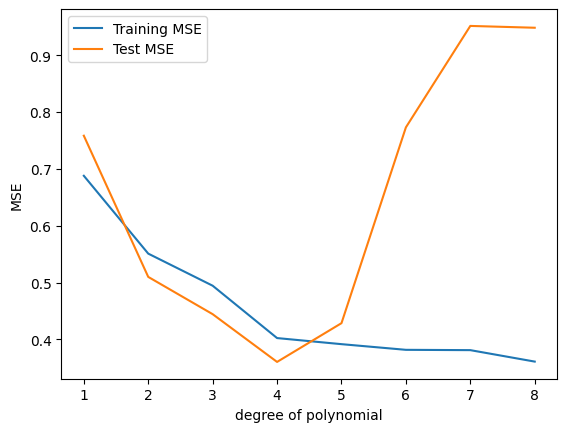

In [40]:
#insert here your solution for Task 10


mse_train = np.zeros(8)
mse_test = np.zeros(8)

for degree in range(1, 9):

    beta_hat_degree, Z = OLS(x_std_concat, degree, Y_concat)

    Z_test_degree = phi(x_std_test, degree)

    mse_train[degree - 1] = mse(Y_concat, Z@beta_hat_degree)
    mse_test[degree - 1] = mse(y_test, Z_test_degree@beta_hat_degree)


plot_fig(mse_train, mse_test, ['Training MSE', 'Test MSE'], 9)

> **Question 5**: Did the MSE improve or not compared to the experiment with validation set?


In [38]:
# k = 4 is still the best but the MSE increased from 0.3034114750346563 to 0.36020903198650034